# Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.


In [1]:
# Importing libraries
import os
import io
import boto3
import sagemaker
from sagemaker import PCA

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import pickle, gzip, urllib, json
import csv

from utils import *

%matplotlib inline

In [2]:
# sagemaker session, role
session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket name
bucket = 'sagemaker-ap-south-1-714138043953'

In [3]:
s3_client = boto3.client('s3')

obj_list = s3_client.list_objects(Bucket=bucket)
file=[]
for contents in obj_list['Contents']:
    file.append(contents['Key'])

print(file)

['arvato-segmentation/attributes.csv', 'arvato-segmentation/azdias.pkl', 'arvato-segmentation/customers.pkl', 'arvato-segmentation/information.csv']


In [4]:
def read_pkl_s3(bucket, key):
    """Function to read pickle files from S3
    :param bucket: S3 bucket name
    :param key: path to file
    :return: data
    """
    response = s3_client.get_object(Bucket=bucket, Key=key)
    body = response['Body'].read()
    data = pickle.loads(body)
    
    return data

In [6]:
azdias = read_pkl_s3(bucket, file[1])
customers = read_pkl_s3(bucket, file[2])

print(azdias.shape)
print("_______"*10)
print(customers.shape)

(791253, 353)
______________________________________________________________________
(140866, 356)


In [7]:
sep_attr = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
customers_az = customers.drop(sep_attr, axis = 1).copy()
customers_az.shape

(140866, 353)


## Pricipal Component Analysis
Before training our machine learning model, we'll reduce the demension of our data for which we'll use **Incremental Principal Component Analysis.** Increamental PCA requires to split data into smaller batches, which are fed to IPCA one at a time.

In [11]:
prefix = 'arvato-segmentation'

num_components = 150

pca_SM = PCA(role=role,
             train_instance_count=1,
             train_instance_type='ml.p2.xlarge',
             output_path='s3://{}/{}/'.format(bucket, prefix),
             num_components=num_components)

In [12]:
%%time
pca_SM.fit(pca_SM.record_set(azdias.values))

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-10-21 22:09:46 Starting - Starting the training job...
2020-10-21 22:09:47 Starting - Launching requested ML instances...
2020-10-21 22:10:46 Starting - Preparing the instances for training.........
2020-10-21 22:12:02 Downloading - Downloading input data......
2020-10-21 22:13:10 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[10/21/2020 22:13:30 INFO 139703499974464] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[10/21/2020 22:13:30 INFO 139703499974464] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'353', u'mini_batch_size': u'500', u'num_

In [15]:
pca_training_job_name = 'pca-2020-10-21-22-09-46-081'

# where the model is saved, by default
pca_model_key = os.path.join(prefix, pca_training_job_name, 'output/model.tar.gz')
print(pca_model_key)

# download and unzip model
boto3.resource('s3').Bucket(bucket).download_file(pca_model_key, 'model.tar.gz')

# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

arvato-segmentation/pca-2020-10-21-22-09-46-081/output/model.tar.gz


2304

In [16]:
import mxnet as mx

# loading the unzipped artifacts
pca_model_params = mx.ndarray.load('model_algo-1')

# what are the params
print(pca_model_params)

{'s': 
[ 704.6282   706.7315   708.7239   711.1028   713.4276   716.2071
  718.74365  720.9439   721.45905  724.19916  724.47314  730.11456
  731.63934  735.4188   736.0123   737.5653   739.991    744.4948
  745.3291   748.4225   749.35645  750.66425  753.1534   757.746
  760.96277  763.6835   767.00824  767.41675  769.6106   771.32965
  774.40625  775.2694   779.8402   780.7153   781.6288   785.5108
  788.5035   789.5478   792.3908   796.4925   797.3434   798.2613
  800.52094  803.954    805.3897   809.591    811.1333   813.5099
  815.0512   818.28937  819.5548   821.28973  825.59204  827.8891
  832.432    834.2066   836.5611   839.289    840.0689   843.56714
  844.8338   847.3176   851.0208   853.7082   855.2297   857.7325
  860.5384   861.1796   864.8787   870.5476   872.4166   875.27484
  886.90045  889.775    891.255    897.8568   901.8539   907.8589
  907.94006  911.9697   916.0122   918.7895   924.0326   927.8112
  937.8108   941.4426   948.2784   952.4517   968.7046   978.3908


### PCA Model Attributes

Three types of model attributes are contained within the PCA model.

    mean: The mean that was subtracted from a component in order to center it.
    v: The makeup of the principal components; (same as ‘components_’ in an sklearn PCA model).
    s: The singular values of the components for the PCA transformation. This does not exactly give the % variance from the original feature space, but can give the % variance from the projected feature space.

We are only interested in v and s.

From s, we can get an approximation of the data variance that is covered in the first n principal components. The approximate explained variance is given by the formula: the sum of squared s values for all top n components over the sum over squared s values for all components:
$$\begin{equation*} \frac{\sum_{n}^{ } s_n^2}{\sum s^2} \end{equation*}$$

From v, we can learn more about the combinations of original features that make up each principal component.


In [17]:
# get selected params
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

In [19]:
# looking at top 5 components
n_principal_components = 5

start_idx = num_components - n_principal_components  # 33-n

# print a selection of s
print(s.iloc[start_idx:, :])

               0
145  2582.603027
146  3295.756104
147  3708.598389
148  3825.171875
149  4890.795410


In [20]:
def explained_variance(s, n_top_components):
    """Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.
    """
#     num_components = 150
    start_idx = num_components - n_top_components
    top_principal_components = s.iloc[start_idx:, :]
    
    variance = np.sum(np.square(top_principal_components)) / np.sum(np.square(s))
    
    return variance[0]

In [23]:
# test cell
n_top_components = 130 # select a value for the number of top components

# calculate the explained variance
exp_variance = explained_variance(s, n_top_components)
print('Explained variance: ', exp_variance)

Explained variance:  0.95604914


In [29]:
def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = num_components-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

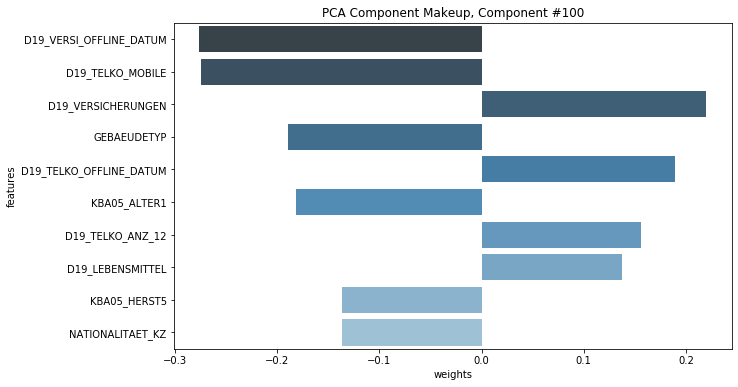

In [30]:
# display makeup of first component
num=100
display_component(v, azdias.columns.values, component_num=num, n_weights=10)

### Deploying PCA Model

In [34]:
%%time
# this takes a little while, around 7mins
# pca_SM = sagemaker.estimator.Estimator.attach(training_job_name) # attaching pre-trained model
pca_predictor = pca_SM.deploy(initial_instance_count=1, 
                              instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Using already existing model: pca-2020-10-21-22-09-46-081


ResourceLimitExceeded: An error occurred (ResourceLimitExceeded) when calling the CreateEndpoint operation: The account-level service limit 'ml.c4.large for endpoint usage' is 0 Instances, with current utilization of 0 Instances and a request delta of 1 Instances. Please contact AWS support to request an increase for this limit.